<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 3: Regression modelling</h2></center>
<br>

In this tutorial we will put the regression modelling tools from Module 4 into practice by using a new dataset.

<a class="buttom" href="#Data">Data</a> <br>
<a class="buttom" href="#Exploratory Data Analysis">Exploratory Data Analysis</a> <br>
<a class="buttom" href="#Creating-new-variables">Creating new variables</a> <br>
<a class="buttom" href="#Linear-regression">Linear regression</a> <br>
<a class="buttom" href="#Predictions">Predictions</a> <br>
<a class="buttom" href="#Question-for-reflection">Question for reflection</a> <br>

This notebook relies on the following imports and settings throughout. We will load new packages and functions in context to make clear what we are using them for. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('notebook')
sns.set(style="ticks", color_codes=True)

###Data

The <TT>Employees.csv</TT> file records data about the employees of a company. The dataset is from [Business Analytics for Managers](http://www.springer.com/us/book/9781461404057) by Wolfgang Jank.  In this problem, the managers are concerned with the issue of equal pay in the company. If we compare male and female employees with the same level of experience, are they paid the same on average?

In recent years, workforce, [HR](https://www-01.ibm.com/software/analytics/solutions/operational-analytics/hr-analytics/), and [people analytics](http://knowledge.wharton.upenn.edu/article/open-sourcing-googles-hr-secrets/) have emerged as terms for the practice of data-driven human capital management. 

In [2]:
data=pd.read_csv('Employees.csv')
data.head(10)

,Gender,Experience,Salary
0,Female,15,78200
1,Female,12,66400
2,Female,15,61200
3,Female,3,61000
4,Female,4,60000
5,Female,4,68000
6,Female,9,59000
7,Female,11,53600
8,Female,16,62600
9,Female,9,62400


In [3]:
len(data)

208

Because our focus is on supervised learning, rather than statistical inference only, we split our data into training and test sets to evaluate the predictive performance of different models. 

In [4]:
train = data.sample(frac=0.7, random_state=25)
test = data[data.index.isin(train.index)==False].copy() # the copy here is for technical reasons
train.head()

,Gender,Experience,Salary
166,Male,4,83000
182,Male,10,94000
170,Male,7,84000
122,Female,15,87600
19,Female,22,84400


While we do not need this here, it is often useful to retrieve all the possible values of a categorical variable in the data. 

In [5]:
train['Gender'].unique()

array(['Male', 'Female'], dtype=object)

###Exploratory data analysis

The next several cells display a range of summary measures and exploratory plots for the data. We learn for example that: 

* Male employees have higher salaries than female employees on average. The pay gap seems to be larger at the upper quantiles of the salary distribution for each group.  The variance in salaries is substantially higher for males.

 
* The distribution of salary is pronouncedly right skewed for both males and females.


* Not surprisingly, experience is strongly positively related to salary. When considering all the employees, three of them appear as outliers as they have much higher salaries than the rest of the employees . These are probably senior executives in the company (further investigation would reveal that they are all males). 


* There seems to be an interaction between gender and experience. The pay gap increases with the level of experience. Allowing for this interaction, the employees with highest salary do not seem to be outliers anymore.

In [6]:
train.groupby('Gender')['Salary'].describe().round(2) 

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,103.0,73769.71,12821.20,53600.0,63900.0,70800.0,82300.0,123000.0
Male,43.0,92493.02,30225.92,54000.0,68500.0,88000.0,106000.0,194000.0


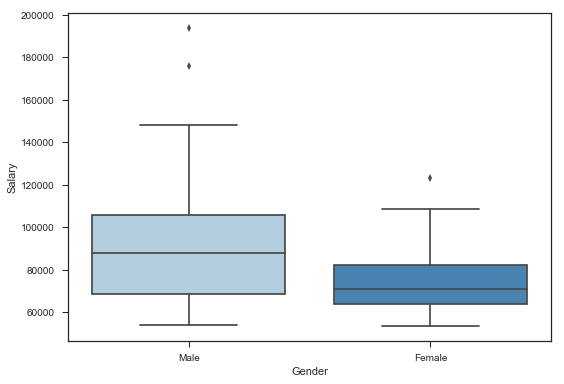

In [7]:
sns.boxplot(x='Gender', y='Salary', data=train, palette='Blues')
plt.tight_layout()
plt.show()

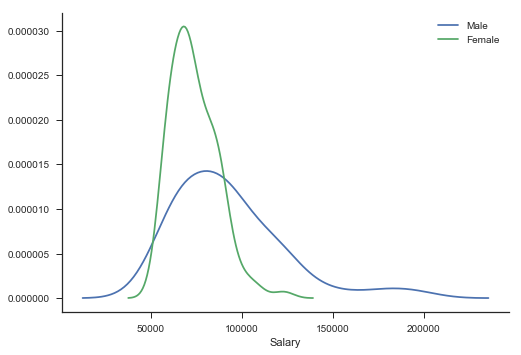

In [8]:
sns.distplot(train.loc[train['Gender']=='Male','Salary'], hist=False, label='Male')
sns.distplot(train.loc[train['Gender']=='Female','Salary'], hist=False, label='Female')
sns.despine()
plt.show()

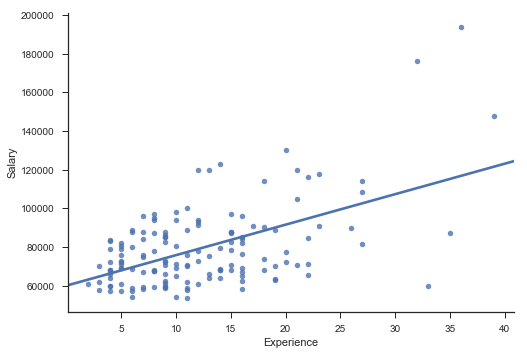

In [9]:
sns.regplot(train['Experience'], train['Salary'], scatter_kws={'s': 30}, ci=None)
sns.despine()
plt.show()

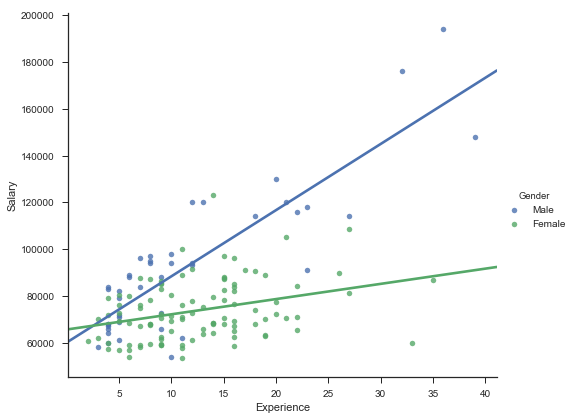

In [10]:
sns.lmplot('Experience', 'Salary', data=train, hue='Gender', size=6, aspect=1.2, scatter_kws={'s': 30}, ci=None)
plt.show()

###Creating new variables

To incorporate the gender predictor into a linear regression model, we need to create a dummy variable. There are two ways of doing this. One is to do it manually as below. 

In [11]:
train['Female']=(train['Gender']=='Female').astype(int) # the last part converts False/True to 0/1
train.head()

,Gender,Experience,Salary,Female
166,Male,4,83000,0
182,Male,10,94000,0
170,Male,7,84000,0
122,Female,15,87600,1
19,Female,22,84400,1


The second is to use the pandas [<TT>get_dummies</TT>](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) function to automatically generate dummies, and then add them back to the DataFrame . 

In [12]:
dummies = pd.get_dummies(train[['Gender']],  drop_first=True)
dummies.head()

,Gender_Male
166,1
182,1
170,1
122,0
19,0


In [13]:
train=train.join(dummies)
train.head(5)

,Gender,Experience,Salary,Female,Gender_Male
166,Male,4,83000,0,1
182,Male,10,94000,0,1
170,Male,7,84000,0,1
122,Female,15,87600,1,0
19,Female,22,84400,1,0


In [14]:
train = train.rename(columns = {'Gender_Male': 'Male'})
train.head()

,Gender,Experience,Salary,Female,Male
166,Male,4,83000,0,1
182,Male,10,94000,0,1
170,Male,7,84000,0,1
122,Female,15,87600,1,0
19,Female,22,84400,1,0


We know however that we should keep only one of these variables. 

In [15]:
train = train.drop('Male', axis=1)

Creating other types of variables is easy. We know that salaries tend to increase in percentage terms every year, so that it is plausible that the relationship between salary and experience may be better described as a log-linear relationship. The log transformation may also help to reduce the positive skewness that we found in the EDA. 

In [16]:
train['LogSalary'] = np.log(train['Salary'])

In [17]:
train['FemaleExp'] = train['Female']*train['Experience']

As a last detail, we also to same predictor processing for the test data (it is generally more convenient to create dummy variables before splitting the data). 

In [18]:
test['Female']=(test['Gender']=='Female').astype(int)
test['FemaleExp'] = test['Female']*test['Experience']

###Linear regression

There are several ways to estimate a linear regresssion in Python. In this tutorial, we use the statmodels package, as it generates [more informative](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.html) outputs and results.

In [19]:
import statsmodels.formula.api as smf

formula='Salary ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     66.56
Date:                Tue, 15 Aug 2017   Prob (F-statistic):           3.70e-21
Time:                        16:06:37   Log-Likelihood:                -1613.7
No. Observations:                 146   AIC:                             3233.
Df Residuals:                     143   BIC:                             3242.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.342e+04   3106.548     23.634      0.0

The output is difficult to read because of the scale of the salary variable. Using the formula approach makes it easier to transform variables for purposes of estimating the regression. 

In [20]:
formula='np.divide(Salary, 1000) ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()
print(ols.summary())

                               OLS Regression Results                              
Dep. Variable:     np.divide(Salary, 1000)   R-squared:                       0.482
Model:                                 OLS   Adj. R-squared:                  0.475
Method:                      Least Squares   F-statistic:                     66.56
Date:                     Tue, 15 Aug 2017   Prob (F-statistic):           3.70e-21
Time:                             16:06:37   Log-Likelihood:                -605.19
No. Observations:                      146   AIC:                             1216.
Df Residuals:                          143   BIC:                             1225.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
In

If were compare a male and female employee with the same level of experience, we would expect the female employee to earn 20.5K less according to this estimate. The coefficient is statistically significant, so that we can reliably conclude that the female employees have lower salaries on average conditional on experience. 

Is this model appropriate for the data? We should use residual diagnostics to check. The diagnostic plot below reveals a nonlinear pattern in the residuals, which means that the linear specification is not correct for this data. We should try to improve the model by considering a log transformation (suggested by domain knowledge and EDA) and an interaction term (suggested by EDA). 

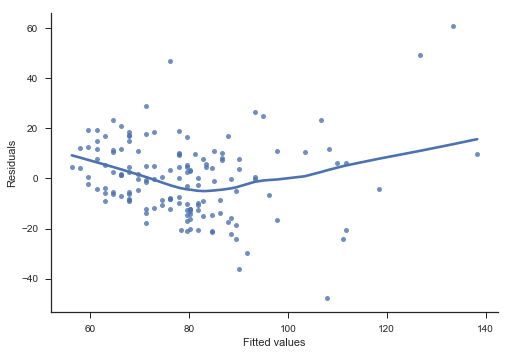

In [21]:
fig, ax= plt.subplots()

# Note how I am getting the fitted values and residuals from the regression results here
# The lowess option fits a nonparametric regression to the scatter plot, allowing us to visualise possible nonlinear patterns

sns.regplot(ols.fittedvalues, ols.resid, scatter_kws={'s' : 25}, lowess=True, ax=ax) 
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted values')
sns.despine()
plt.show()

Interpret the two models below (especially the coefficients for all variables). Are the conclusions the same?

In [22]:
formula='LogSalary ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:              LogSalary   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     54.59
Date:                Tue, 15 Aug 2017   Prob (F-statistic):           2.42e-18
Time:                        16:06:38   Log-Likelihood:                 49.581
No. Observations:                 146   AIC:                            -93.16
Df Residuals:                     143   BIC:                            -84.21
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1971      0.035    319.532      0.0

In [23]:
formula='LogSalary ~ Female + Experience + FemaleExp'
ols = smf.ols(formula=formula, data=train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:              LogSalary   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     49.79
Date:                Tue, 15 Aug 2017   Prob (F-statistic):           4.75e-22
Time:                        16:06:38   Log-Likelihood:                 60.635
No. Observations:                 146   AIC:                            -113.3
Df Residuals:                     142   BIC:                            -101.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.0870      0.040    278.523      0.0

We would have achieved the same result by using the formula below, which would not require creating the log and interaction variables beforehand. The need for creating new variables depends on the context. 

In [24]:
formula='np.log(Salary) ~ Female + Experience + Female:Experience'

We can check the this last specification improves the residuals.

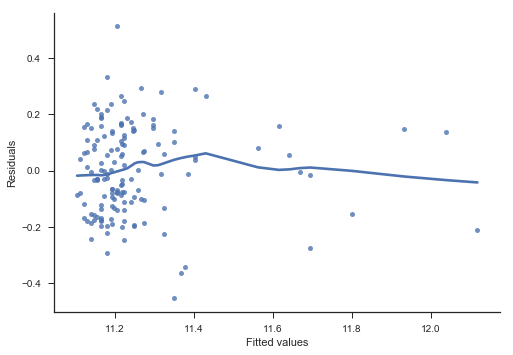

In [25]:
fig, ax= plt.subplots()
sns.regplot(ols.fittedvalues, ols.resid, scatter_kws={'s' : 25}, lowess=True, ax=ax)
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted values')
sns.despine()
plt.show()

##Predictions

We now compare different specifications on the test data. Note that for the models with a log transformed response, we should use an appropriate retransformation and adjustment when computing the predictions for salary. 

We should be careful with our analysis since there are only a few test cases. Here are some tentative conclusions. 

* The specifications with the interaction term predict better than the ones without.


* When comparing the two specifications without interaction, the model with a log transformation seems to perform better. 


* When comparing the two specifications with the interaction term, the log model may have slightly better predictive ability.


* The adjustment for retransformation is small, and does not make much difference in performance for this exmaplii.

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rmse=[]
r2=[]

# Model 1
formula='Salary ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()
predictions = ols.predict(test) # no need to select the predictors in this case 
rmse.append(np.sqrt(mean_squared_error(test['Salary'], predictions)))
r2.append(r2_score(test['Salary'], predictions))

# Model 2
formula='Salary ~ Female + Experience + Experience:Female'
ols = smf.ols(formula=formula, data=train).fit()
predictions = ols.predict(test)
rmse.append(np.sqrt(mean_squared_error(test['Salary'], predictions)))
r2.append(r2_score(test['Salary'], predictions))

# Model 3
formula='np.log(Salary) ~ Female + Experience'
ols = smf.ols(formula=formula, data=train).fit()
predictions = np.exp(ols.predict(test))*np.mean(np.exp(ols.resid))
rmse.append(np.sqrt(mean_squared_error(test['Salary'], predictions)))
r2.append(r2_score(test['Salary'], predictions))

# Without adjustment for the retransformation, for comparison
predictions = np.exp(ols.predict(test))
rmse.append(np.sqrt(mean_squared_error(test['Salary'], predictions)))
r2.append(r2_score(test['Salary'], predictions))

# Model 4
formula='np.log(Salary) ~ Female + Experience + Experience:Female'
ols= smf.ols(formula=formula, data=train).fit()
predictions = np.exp(ols.predict(test))*np.mean(np.exp(ols.resid))
rmse.append(np.sqrt(mean_squared_error(test['Salary'], predictions)))
r2.append(r2_score(test['Salary'], predictions))

# Without adjustment for the retransformation, for comparison
predictions = np.exp(ols.predict(test))
rmse.append(np.sqrt(mean_squared_error(test['Salary'], predictions)))
r2.append(r2_score(test['Salary'], predictions))

print(np.array(rmse).round(2))
print('\n')
print(np.array(r2).round(3))

[ 20152.31  18898.08  19359.7   19443.38  18303.27  18246.2 ]


[ 0.354  0.432  0.404  0.399  0.467  0.47 ]


In [27]:
round(np.mean(np.exp(ols.resid)),3)

1.013

##Question for reflection

Does this analysis allows us to conclude that there is gender discrimination in the company? Why or why not? You can post your answer on Ed for discussion and feedback.

